In [1]:
import pandas as pd
import seaborn as sns
#import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
import numpy as np
import sys, os, gc, traceback
from sklearn.preprocessing import LabelEncoder
#! pip install missingno
import missingno as msno
#! pip install impyute
from impyute.imputation.cs import mice
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from matplotlib import cm
from sklearn.decomposition import PCA

import time
from sklearn.metrics import precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

from sklearn.svm import SVC
import pickle
from sklearn.model_selection import RandomizedSearchCV, cross_validate, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score,fbeta_score, roc_auc_score, accuracy_score, classification_report


Using TensorFlow backend.


In [5]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential

In [52]:
def getData(fileName):
        
        # get the current directory

        dirName = os.getcwd()
        # Concatenate directory with files
        dataFilePath = os.path.join(dirName,fileName)
        data = pd.read_csv(dataFilePath, index_col=0)
        
        columns=list(data.columns)
        print(f'Available columns: {columns}')
        matching=[s for s in columns if 'date' in s]
        print(f'Column with date :{matching}')
        if matching:
            data=convert_index_todatetime(data, ''.join(matching))
            print(f' column info :{data.info()}')
            data=data.drop(columns=matching)
        
        return data
def convert_index_todatetime(df,col):
        df[col]=pd.to_datetime(df[col])
        df.index=df[col]
        return df


In [9]:
# NN hyperparameters
w=20
p_w=1
kernel_size=3
n_filters_conv1=16
n_filters_conv2=16
n_out=p_w
s_pool=2
n_features=1


In [23]:
def convert_seq_to_vectors(df):
    sc=MinMaxScaler(feature_range=(0,1))
    df.loc[:,:]=sc.fit_transform(df)
    data_arr=df.to_numpy()
    X=np.zeros(shape=(df.shape[0]-w, w, df.shape[1]))    
    y=np.zeros(shape=(df.shape[0]-w, df.shape[1]))    
    for i in range(w-1, df.shape[0]-1):
        y[i-w+1]=data_arr[i+1]
        for j in range(i-w+1,i+1):
            X[i-w+1][w-1-i+j]=data_arr[j]
    
    return X,y

    

In [8]:
def split_data(X, y):
    limit=int(X.shape[0]*.8)
    xtr=X[0:limit]
    ytr=y[0:limit]
    xtst=X[limit:]
    ytst=y[limit:]
    return xtr, ytr, xtst, ytst
    
    

In [10]:
def DeepAnt():
    model=Sequential()
    model.add(Conv1D(filters=n_filters_conv1, kernel_size=kernel_size,activation='relu', input_shape=(w, n_features)))
    model.add(MaxPooling1D(s_pool))
    model.add(Conv1D(filters=n_filters_conv2, kernel_size=kernel_size,activation='relu'))
    model.add(MaxPooling1D(s_pool))
    model.add(Flatten())
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model
    
    
    

In [13]:
def train_model(model, X, y, epochs):
    model.fit(X, y, epochs=epochs, verbose=1)
    return model

In [16]:
def model_evaluate(model, xtest):
    y_pred=model.predict(xtest)
    return y_pred
    


In [17]:
def anomaly_detector(y_pred, y_true, thres):
    d=np.linalg.norm(y_true-y_pred)
    if d>thres:
        return True
    else:
        return False
def calculate_loss(y_pred, y_true):
    d=np.linalg.norm(y_true-y_pred)
    return d
    

Dataset size: (9357, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 18, 16)            64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 16)             784       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1960      
_________________________________________________________________
dropout_1 (Dropout)          (

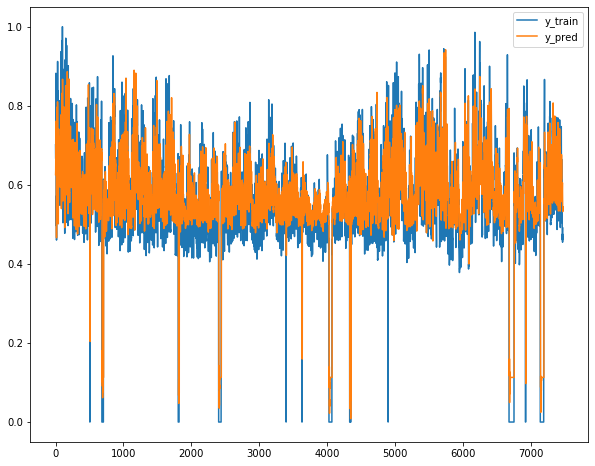

In [24]:
# Read the dataset
ds_name='Air_quality_uni.csv'
uni_rawdata = pd.read_csv(os.path.join(os.getcwd(),ds_name), index_col=0)
print(f'Dataset size: {uni_rawdata.shape}')
df=uni_rawdata.copy()
#convert into vectors
X, y=convert_seq_to_vectors(df)
# initialize the DeepAnt model
model=DeepAnt()
print(f'Model summary:{model.summary()}')
# split the data
x_train, y_train, x_test, y_test=split_data(X, y)
# Train the model
model_trained=train_model(model,x_train, y_train, epochs=30)
# Evaluate the model
y_pred=model_evaluate(model_trained, x_train)
# check for anomaly
results=pd.DataFrame(y_train)
results.columns=['y_train']
results['y_pred']=y_pred
results['Anomaly']=[anomaly_detector(y_train[i], y_pred[i], .5) for i in range(len(y_train))]
print(f' Check anomaly: {results}')
# Visualize the data
plt.figure(figsize=(10,8))
results.y_train.plot()
results.y_pred.plot()
plt.legend()
plt.show()

Available columns: ['room_id/id', 'noted_date', 'temp', 'out/in']
Column with date :['noted_date']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97606 entries, 2018-08-12 09:30:00 to 2018-07-28 07:06:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   room_id/id  97606 non-null  object        
 1   noted_date  97606 non-null  datetime64[ns]
 2   temp        97606 non-null  int64         
 3   out/in      97606 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.7+ MB
 column info :None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 18, 16)            64        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 9, 16)             0         
______________________________

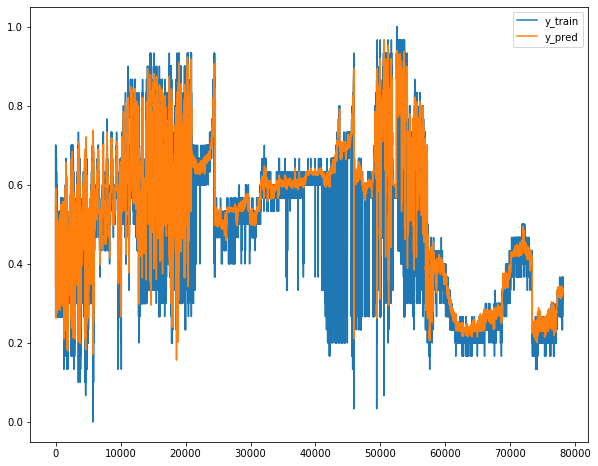

 Check anomaly:          y_test    y_pred  Anomaly
0      0.333333  0.336454    False
1      0.300000  0.343552    False
2      0.333333  0.343541    False
3      0.300000  0.340903    False
4      0.333333  0.340552    False
...         ...       ...      ...
19513  0.333333  0.359007    False
19514  0.333333  0.358459    False
19515  0.333333  0.356472    False
19516  0.333333  0.356227    False
19517  0.333333  0.359318    False

[19518 rows x 3 columns]


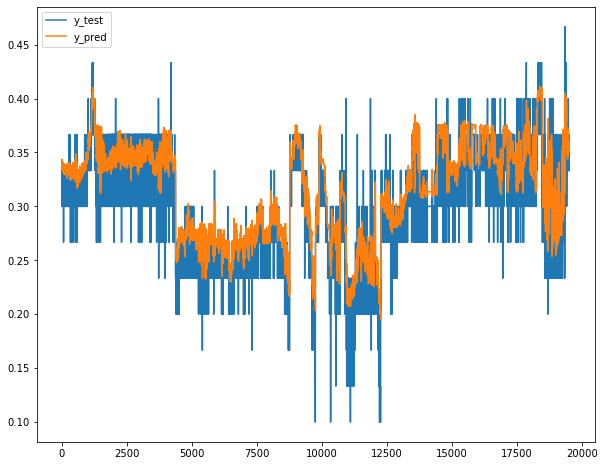

In [59]:
uni_rawdata=getData(ds_name)
uni_rawdata.drop(columns=['room_id/id','out/in'], axis=1, inplace=True)
df=uni_rawdata.copy()
#convert into vectors
X, y=convert_seq_to_vectors(df)
# initialize the DeepAnt model
model=DeepAnt()
print(f'Model summary:{model.summary()}')
# split the data
x_train, y_train, x_test, y_test=split_data(X, y)
# Train the model
model_trained=train_model(model,x_train, y_train, epochs=30)
# Evaluate the model
y_pred=model_evaluate(model_trained, x_train)
# check for anomaly
results=pd.DataFrame(y_train)
results.columns=['y_train']
results['y_pred']=y_pred
results['Anomaly']=[anomaly_detector(y_train[i], y_pred[i], .5) for i in range(len(y_train))]
print(f' Check anomaly: {results}')
# Visualize the data
plt.figure(figsize=(10,8))
results.y_train.plot()
results.y_pred.plot()
plt.legend()
plt.show()

# Evaluate the model on test data
y_pred_test=model_evaluate(model_trained, x_test)

# check for anomaly
results_test=pd.DataFrame(y_test)
results_test.columns=['y_test']
results_test['y_pred']=y_pred_test
results_test['Anomaly']=[anomaly_detector(y_test[i], y_pred_test[i], .5) for i in range(len(y_test))]
print(f' Check anomaly: \n{results_test}')
# Visualize the data
plt.figure(figsize=(10,8))
results_test.y_test.plot()
results_test.y_pred.plot()
plt.legend()
plt.show()